# TP Aprendizaje supervisado

In [1]:
''''
Merge lab de Rodri + Flor:
1)	No se tiene en cuenta la variable Tiempo( si en el de Flor original, para mejorar habría que agregarlo)
2)	Curación sigue con el criterio de Rodri( escaldo, nans, etc)
3)	Se agregan gráficos de Flor
4)	Se toman los modelos: DecisionTreeClassifier, ensemble.RandomForestClassifier y XGBClassifier (con los parámetros originales de Flor).
Este último se usa para archivo "sample_submission.csv" 
''''

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
#Importación modulos Flor
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn import ensemble

from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [3]:
# General params

RANDOM_STATE = 45
IMPUTE_NULLS = True
ENCODER = OneHotEncoder
TRAIN_SIZE = 0.85

## Carga del data set

In [4]:
full_train_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/test.csv')
full_train_df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.0,NaN,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0
5,7586,Earth,False,F/1553/S,PSO J318.5-22,23.0,False,90.0,4.0,0.0,7.0,588.0,Benda Dickley,0
6,2358,Mars,False,E/153/P,TRAPPIST-1e,29.0,False,834.0,0.0,28.0,117.0,41.0,Quid Dutte,0
7,6887,Europa,False,D/227/P,TRAPPIST-1e,36.0,False,31.0,3585.0,31.0,1400.0,0.0,Suhaino Bruthydre,0
8,3263,Earth,False,F/723/P,TRAPPIST-1e,38.0,False,0.0,1025.0,23.0,0.0,0.0,Mon Clemondsey,1
9,2602,Earth,True,G/450/P,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Idave Carverson,0


## Análisis exploratorio

In [5]:
full_train_df.shape

(7823, 14)

In [6]:
full_train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [7]:
print("Ratio de distribucion de clases {:.4f}".format(len(full_train_df[full_train_df["Transported"] == False]) / len(full_train_df[full_train_df["Transported"] == True])))

Ratio de distribucion de clases 0.9735


### Análisis descriptivo

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/train.csv')
print(df.shape)
print(df.describe())

(7823, 14)
       PassengerId          Age   RoomService     FoodCourt  ShoppingMall  \
count  7823.000000  7661.000000   7669.000000   7668.000000   7635.000000   
mean   4345.691039    28.879389    226.078237    455.643062    172.600393   
std    2504.576803    14.461548    679.180148   1621.290107    597.923749   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%    2182.500000    19.000000      0.000000      0.000000      0.000000   
50%    4345.000000    27.000000      0.000000      0.000000      0.000000   
75%    6515.500000    38.000000     44.000000     69.000000     28.000000   
max    8692.000000    79.000000  14327.000000  29813.000000  23492.000000   

                Spa        VRDeck  Transported  
count   7665.000000   7654.000000  7823.000000  
mean     305.023222    295.476744     0.506711  
std     1133.423579   1093.485752     0.499987  
min        0.000000      0.000000     0.000000  
25%        0.000000      0.000000     0.000000  
5

In [9]:
# data.isna() devuelve una matriz de booleanos en la que cada posicion indica si ese valor esta perdido o no. Hacer .sum() suma sobre los valores
# True de esa matriz y haciendo ascending=False le pedimos que nos de las columnas con mas valores perdidos
nans = df.isna().sum().sort_values(ascending=False)
print(nans[nans!=0]/df.shape[0]) #Aca nos da la proporcion de valores perdidos de cada columna 

CryoSleep       0.025054
ShoppingMall    0.024032
Cabin           0.023520
VIP             0.023520
Name            0.023520
HomePlanet      0.022881
VRDeck          0.021603
Age             0.020708
Destination     0.020453
Spa             0.020197
FoodCourt       0.019813
RoomService     0.019686
dtype: float64


In [10]:
df = df.dropna(axis=0, subset=['CryoSleep', 'VIP', 'HomePlanet', 'Destination'])
print(len(df.index)) #perdimos 600 datos, lo cual representa el 9% de los datos

7123


<Figure size 720x720 with 0 Axes>

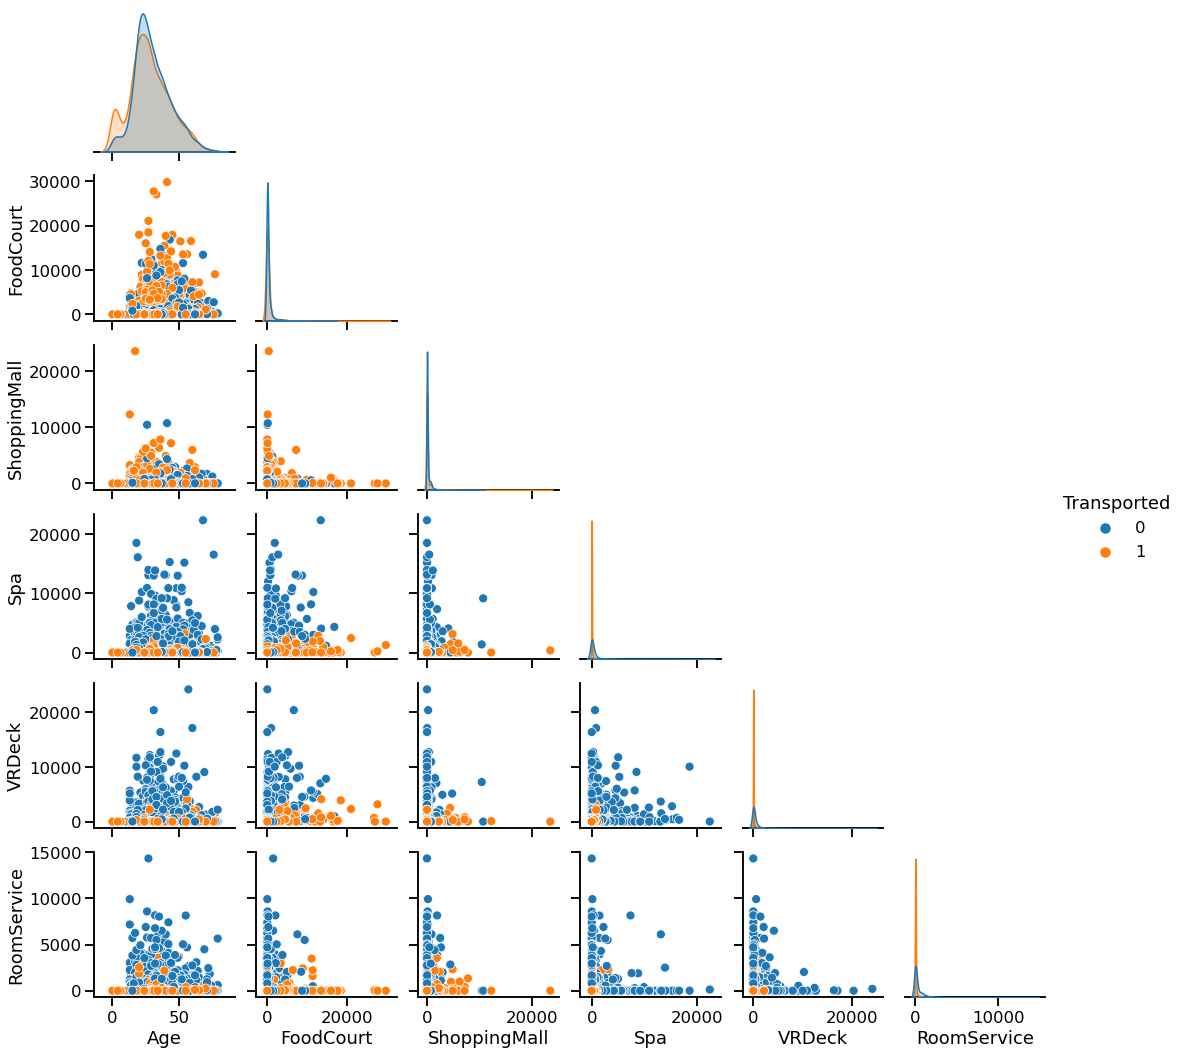

In [11]:
col = ['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']
dat = df[col]
dat = dat.join(df.Transported)
fig = plt.figure(figsize=(10,10))
sns.pairplot(dat, hue='Transported', corner=True)
#plt.savefig('pairplot_6.jpg', bbox_inches = 'tight')

<AxesSubplot:ylabel='Sueño criogénico'>

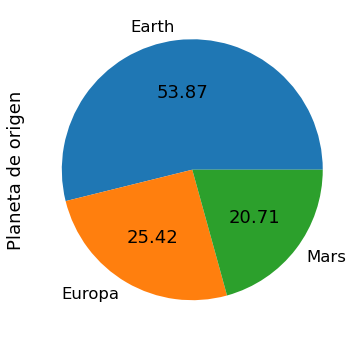

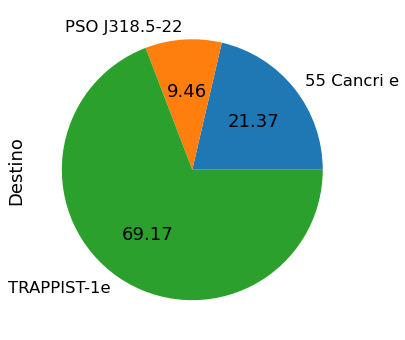

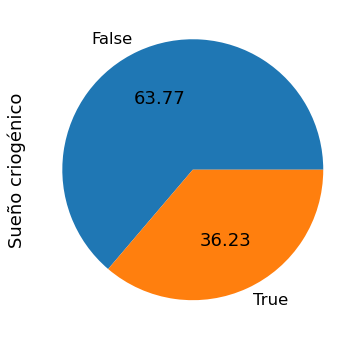

In [12]:
fig = plt.figure(figsize = (6,6))
df.groupby('HomePlanet').size().plot(kind='pie', ylabel = 'Planeta de origen', autopct='%.2f')

fig = plt.figure(figsize = (6,6))
df.groupby('Destination').size().plot(kind='pie', ylabel = 'Destino', autopct='%.2f')

fig = plt.figure(figsize = (6,6))
df.groupby('CryoSleep').size().plot(kind='pie', ylabel = 'Sueño criogénico', autopct='%.2f')

### Tratamiento de nulos

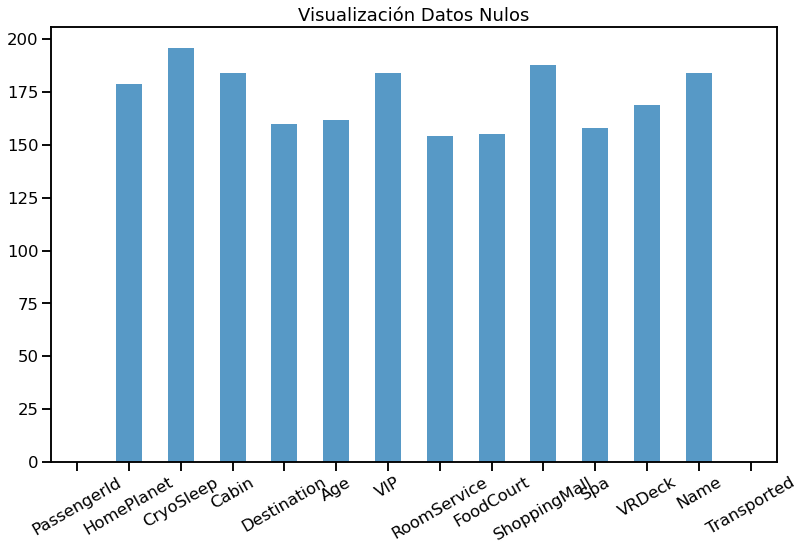

In [13]:
full_train_df.isna().sum().plot(kind='bar', rot=30, alpha=0.75, figsize=(13,8)).set_title("Visualización Datos Nulos")
plt.show()

<AxesSubplot:>

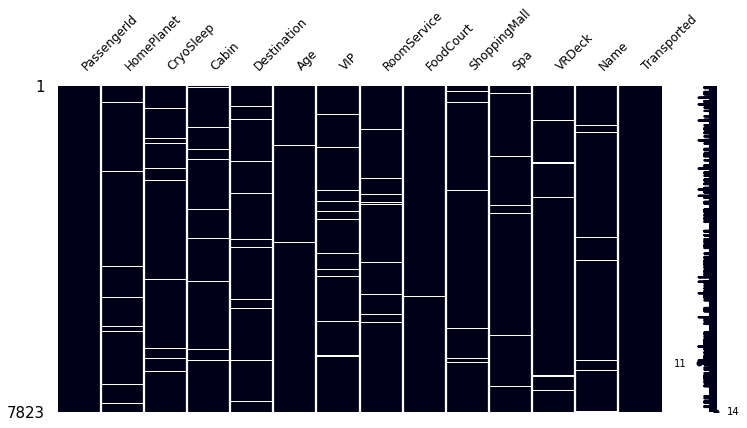

In [14]:
import missingno as msno
msno.matrix(full_train_df,figsize=(12, 6), fontsize=12, color=[0,0,0.1])

In [15]:
numeric_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService", "CryoSleep", "VIP"]
categorical_cols = ["HomePlanet", "Destination", "Floor", "Side"]

def clean_nulls(df,impute_nulls):
  imputed_full_df = df
  if impute_nulls:
    from sklearn.impute import KNNImputer
    imputer = KNNImputer()
    imputed_full_df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    imputed_full_df = imputed_full_df.dropna()
  else:
    imputed_full_df = df.dropna()
  return imputed_full_df


In [16]:
imputed_full_df = clean_nulls(full_train_df, IMPUTE_NULLS)
print("Ratio de distribucion de clases luego de eliminar los nan {:.4f}".format(len(imputed_full_df[imputed_full_df["Transported"] == False]) / len(imputed_full_df[imputed_full_df["Transported"] == True])))

print("Validación de que no quedan nulos. Cantidad de nulos: {}".format(imputed_full_df.isna().sum().sum()))

Ratio de distribucion de clases luego de eliminar los nan 0.9740
Validación de que no quedan nulos. Cantidad de nulos: 0


### Selección de columnas y split de valores

In [17]:
def fit_columns(df):
  # Se elimina la columna name por que no es un dato relevante par el análisis
  if "Name" in df:
    df = df.drop(columns=['Name'])

  # Se separan como distintas features las partes de la culumna 'Cabin'
  if "Cabin" in df:
    df[["Floor","Number","Side"]] = df.Cabin.str.split("/",expand=True)
    df = df.drop(columns = ["Cabin"])
  return df

In [18]:
imputed_full_df = fit_columns(imputed_full_df)

In [19]:
imputed_full_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Floor', 'Number', 'Side'],
      dtype='object')

## Aplicación de encoding para categóricas

Para cada variable categórica hago una exploración para entender cuantos valores puede tomar cada una y en base a esto analizar la posibilidad de aplicar one_hot_encoding

In [20]:
pd.value_counts(imputed_full_df.HomePlanet)

Earth     3846
Europa    1806
Mars      1488
Name: HomePlanet, dtype: int64

In [21]:
pd.value_counts(imputed_full_df.Destination)

TRAPPIST-1e      4950
55 Cancri e      1515
PSO J318.5-22     675
Name: Destination, dtype: int64

In [22]:
pd.value_counts(imputed_full_df.Floor)

F    2310
G    2158
E     736
B     658
C     644
D     409
A     223
T       2
Name: Floor, dtype: int64

In [23]:
pd.value_counts(imputed_full_df.Side)

S    3584
P    3556
Name: Side, dtype: int64

Los valores de cada variables son relativamente pequeños, por lo tanto al aplicar one hot, deberían quedar 16 columnas nuevas y 4 columnas menos = 12 columnas más

In [24]:
def encode(df):
  encoder = ENCODER().fit(df[categorical_cols])
  sparse_matrix = encoder.transform(df[categorical_cols])
  encoded_categoricals_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns = encoder.get_feature_names_out())
  return encoded_categoricals_df

encoded_categoricals_df = encode(imputed_full_df)
encoded_categoricals_df

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Floor_A,Floor_B,Floor_C,Floor_D,Floor_E,Floor_F,Floor_G,Floor_T,Side_P,Side_S
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7136,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7137,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7138,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [25]:
encoded_categoricals_df.columns

Index(['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Floor_A', 'Floor_B', 'Floor_C', 'Floor_D',
       'Floor_E', 'Floor_F', 'Floor_G', 'Floor_T', 'Side_P', 'Side_S'],
      dtype='object')

## Escalado para los campos numéricos

In [26]:
def scale_numericals(df):
  numerical_df = df[numeric_cols]

  scaled_numerical_df = StandardScaler().fit_transform(numerical_df)
  scaled_numerical_df = pd.DataFrame(scaled_numerical_df, columns=numeric_cols)
  return scaled_numerical_df

scaled_numerical_df = scale_numericals(imputed_full_df)
scaled_numerical_df

,Age,FoodCourt,ShoppingMall,Spa,VRDeck,RoomService,CryoSleep,VIP
0,1.957209,2.059338,-0.292729,-0.093823,3.343312,-0.341725,-0.764172,-0.159056
1,0.287486,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,1.318978,-0.159056
2,0.983204,0.452698,-0.316632,-0.270872,-0.083960,-0.123463,-0.764172,-0.159056
3,-0.686520,-0.279411,0.915301,-0.269964,-0.242716,-0.341725,-0.764172,-0.159056
4,-0.408233,-0.276986,-0.316632,-0.264516,0.274643,-0.203390,-0.764172,-0.159056
...,...,...,...,...,...,...,...,...
7135,-1.173522,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,-0.764172,-0.159056
7136,1.052775,-0.279411,1.051365,-0.214579,-0.271666,-0.341725,-0.764172,-0.159056
7137,1.818065,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,1.318978,-0.159056
7138,-0.964807,0.229672,-0.090471,-0.270872,-0.255790,-0.341725,-0.764172,-0.159056


In [27]:
scaled_numerical_df.columns

Index(['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService',
       'CryoSleep', 'VIP'],
      dtype='object')

## Combinado del DF

In [28]:
X = scaled_numerical_df.join(encoded_categoricals_df)
X

,Age,FoodCourt,ShoppingMall,Spa,VRDeck,RoomService,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,...,Floor_A,Floor_B,Floor_C,Floor_D,Floor_E,Floor_F,Floor_G,Floor_T,Side_P,Side_S
0,1.957209,2.059338,-0.292729,-0.093823,3.343312,-0.341725,-0.764172,-0.159056,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.287486,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,1.318978,-0.159056,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.983204,0.452698,-0.316632,-0.270872,-0.083960,-0.123463,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.686520,-0.279411,0.915301,-0.269964,-0.242716,-0.341725,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.408233,-0.276986,-0.316632,-0.264516,0.274643,-0.203390,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,-1.173522,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,-0.764172,-0.159056,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7136,1.052775,-0.279411,1.051365,-0.214579,-0.271666,-0.341725,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7137,1.818065,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,1.318978,-0.159056,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7138,-0.964807,0.229672,-0.090471,-0.270872,-0.255790,-0.341725,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [29]:
X.columns

Index(['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService',
       'CryoSleep', 'VIP', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Floor_A',
       'Floor_B', 'Floor_C', 'Floor_D', 'Floor_E', 'Floor_F', 'Floor_G',
       'Floor_T', 'Side_P', 'Side_S'],
      dtype='object')

In [30]:
X.shape

(7140, 24)

## Armado de los sets de validación y training

In [31]:
x_train, x_validation, y_train, y_validation = train_test_split(X, imputed_full_df["Transported"], train_size=TRAIN_SIZE, random_state = RANDOM_STATE)

## Creación de modelos

In [32]:
clfs = [DecisionTreeClassifier(), ensemble.RandomForestClassifier(), linear_model.LogisticRegressionCV(solver='sag',max_iter=3000), linear_model.SGDClassifier(), 
        SVC(kernel='poly'), NuSVC(kernel='poly'), LinearSVC(max_iter=50000), DecisionTreeClassifier(criterion='entropy'), 
        ExtraTreeClassifier(), XGBClassifier()]
names = ['Desicion Tree Classifier','Random Forest', 'Logistic Regression', 'SGDC', 'SVC', 'NuSVC', 'Linear SVC', 
         'Desicion Tree Classifier-entropy', 'Extra Trees', 'XGB']

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train, y_train)
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    train_predictions = clf.predict(x_validation)
    accuracy = accuracy_score(y_validation, train_predictions)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)


Desicion Tree Classifier
Accuracy train Desicion Tree Classifier: 94.97%
Accuracy test Desicion Tree Classifier: 74.04%
Random Forest
Accuracy train Random Forest: 94.97%
Accuracy test Random Forest: 79.93%
Logistic Regression
Accuracy train Logistic Regression: 79.45%
Accuracy test Logistic Regression: 79.18%
SGDC
Accuracy train SGDC: 79.34%
Accuracy test SGDC: 78.24%
SVC
Accuracy train SVC: 80.94%
Accuracy test SVC: 80.30%
NuSVC
Accuracy train NuSVC: 79.91%
Accuracy test NuSVC: 79.46%
Linear SVC
Accuracy train Linear SVC: 79.44%
Accuracy test Linear SVC: 80.11%
Desicion Tree Classifier-entropy
Accuracy train Desicion Tree Classifier-entropy: 94.97%
Accuracy test Desicion Tree Classifier-entropy: 74.98%
Extra Trees
Accuracy train Extra Trees: 94.97%
Accuracy test Extra Trees: 72.74%
XGB
Accuracy train XGB: 91.07%
Accuracy test XGB: 80.39%


## Ajuste de hiperparámetros

In [33]:
grid = GridSearchCV(DecisionTreeClassifier(),
 {'criterion':('gini','entropy'),
 'splitter':("best","random"),
 'max_depth':(10,20,100)})
grid.fit(x_train,y_train)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}

In [34]:
#habría que jugar un poco mas con los parametros
grid = GridSearchCV(ensemble.RandomForestClassifier(),
 {'criterion':('gini','entropy', 'log_loss'),
 'max_depth':(10,20,100,500)})
grid.fit(x_train,y_train)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 10}

In [35]:
estimator = XGBClassifier(eval_metric='mlogloss')
n_estimators = [50, 150, 200, 250, 300]
max_depth = [1,3,5,7,9]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2]
#eval_metric = 
#min_child_weight = range(1,6,2) 
#reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', 
                                 n_jobs=None, cv=None, verbose=4, refit=True)
grid_result = grid_search.fit(x_train,y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.735 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.718 total time=   0.0s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.736 total time=   0.0s
[CV 4/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.698 total time=   0.0s
[CV 5/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.711 total time=   0.0s
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.735 total time=   0.2s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.718 total time=   0.2s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.736 total time=   0.2s
[CV 4/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.698 total time=   0.2s
[CV 5/5] END learning_rate=0.0001, max_depth=1, n_estimators

[CV 5/5] END learning_rate=0.0001, max_depth=7, n_estimators=150;, score=0.786 total time=   0.8s
[CV 1/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.777 total time=   1.0s
[CV 2/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.783 total time=   1.1s
[CV 3/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.803 total time=   1.2s
[CV 4/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.754 total time=   1.0s
[CV 5/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.785 total time=   1.0s
[CV 1/5] END learning_rate=0.0001, max_depth=7, n_estimators=250;, score=0.778 total time=   1.2s
[CV 2/5] END learning_rate=0.0001, max_depth=7, n_estimators=250;, score=0.783 total time=   1.2s
[CV 3/5] END learning_rate=0.0001, max_depth=7, n_estimators=250;, score=0.802 total time=   1.2s
[CV 4/5] END learning_rate=0.0001, max_depth=7, n_estimators=250;, score=0.754 total time=   1.1s
[CV 5/5] END learnin

[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=250;, score=0.753 total time=   0.6s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.772 total time=   0.7s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.736 total time=   0.7s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.771 total time=   0.7s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.741 total time=   0.7s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.753 total time=   0.9s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.787 total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.768 total time=   0.2s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.787 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.745 total time=   0.2s
[CV 5/5] END learning_rate=0.001, 

[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.735 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.718 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.737 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.698 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.711 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.735 total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.718 total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.737 total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.699 total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.711 total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_dep

[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.800 total time=   1.2s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.825 total time=   1.2s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.769 total time=   1.2s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.807 total time=   1.3s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.810 total time=   1.4s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.803 total time=   1.4s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.826 total time=   1.9s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.769 total time=   1.5s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.809 total time=   1.4s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=50;, score=0.784 total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_dept

[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.779 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.819 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.803 total time=   0.5s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.804 total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.824 total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.782 total time=   0.5s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.815 total time=   0.6s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.804 total time=   0.7s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.799 total time=   0.6s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.825 total time=   0.6s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estim

[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.802 total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.794 total time=   0.4s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.805 total time=   0.4s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.769 total time=   0.4s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.800 total time=   0.4s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.801 total time=   0.5s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.798 total time=   0.5s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.808 total time=   0.5s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.768 total time=   0.5s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.800 total time=   0.5s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_est

[CV 3/5] END learning_rate=0.2, max_depth=9, n_estimators=50;, score=0.822 total time=   0.3s
[CV 4/5] END learning_rate=0.2, max_depth=9, n_estimators=50;, score=0.768 total time=   0.3s
[CV 5/5] END learning_rate=0.2, max_depth=9, n_estimators=50;, score=0.810 total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.798 total time=   0.8s
[CV 2/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.788 total time=   0.8s
[CV 3/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.821 total time=   0.7s
[CV 4/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.778 total time=   0.7s
[CV 5/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.796 total time=   0.8s
[CV 1/5] END learning_rate=0.2, max_depth=9, n_estimators=200;, score=0.792 total time=   1.0s
[CV 2/5] END learning_rate=0.2, max_depth=9, n_estimators=200;, score=0.788 total time=   1.1s
[CV 3/5] END learning_rate=0.2, max_depth=9, n_estima

In [36]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}

### Plot de las métricas

Accuracy train Arbol de decisión: 83.52%
Accuracy test Arbol de decisión: 77.12%


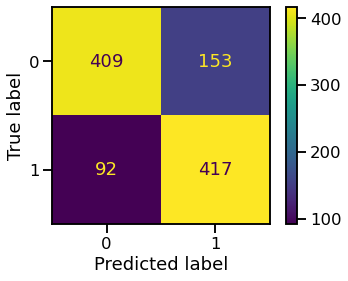

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       562
           1       0.73      0.82      0.77       509

    accuracy                           0.77      1071
   macro avg       0.77      0.77      0.77      1071
weighted avg       0.78      0.77      0.77      1071



In [37]:
clf = DecisionTreeClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(x_validation)
accuracy = accuracy_score(y_validation, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_validation, test_predictions)
plt.show()

print(classification_report(y_validation,clf.predict(x_validation)))


Accuracy train Arbol de decisión: 85.99%
Accuracy test Arbol de decisión: 80.30%


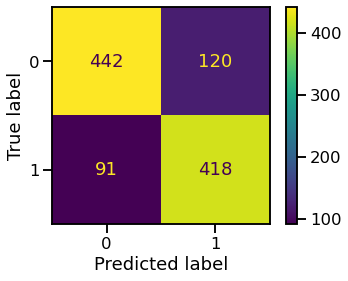

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       562
           1       0.78      0.82      0.80       509

    accuracy                           0.80      1071
   macro avg       0.80      0.80      0.80      1071
weighted avg       0.80      0.80      0.80      1071



In [38]:
clf = ensemble.RandomForestClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(x_validation)
accuracy = accuracy_score(y_validation, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_validation, test_predictions)
plt.show()

print(classification_report(y_validation,clf.predict(x_validation)))

Accuracy train XGB: 85.43%
Accuracy test XGB: 80.58%


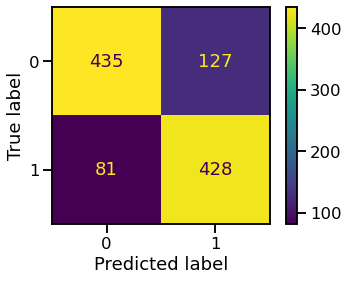

              precision    recall  f1-score   support

           0       0.84      0.77      0.81       562
           1       0.77      0.84      0.80       509

    accuracy                           0.81      1071
   macro avg       0.81      0.81      0.81      1071
weighted avg       0.81      0.81      0.81      1071



In [39]:
clf = XGBClassifier(**grid_search.best_params_).fit(x_train, y_train)

train_predictions = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train XGB: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(x_validation)
accuracy = accuracy_score(y_validation, test_predictions)
print("Accuracy test XGB: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_validation, test_predictions)
plt.show()

print(classification_report(y_validation,clf.predict(x_validation)))

### Entrenamiento del mejor modelo utilizando folds

In [40]:
names = ['Desicion Tree Classifier','Random Forest', 'Logistic Regression', 'SGDC', 'SVC', 'NuSVC', 'Linear SVC', 
         'Desicion Tree Classifier-entropy', 'Extra Trees', 'XGB']

FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train)
y_train2 = np.array(y_train)


for clfi, name in zip([DecisionTreeClassifier(**grid.best_params_),ensemble.RandomForestClassifier(), linear_model.LogisticRegressionCV(solver='sag',max_iter=3000), 
                       linear_model.SGDClassifier(), SVC(kernel='poly'), NuSVC(kernel='poly'), LinearSVC(max_iter=50000), 
                       DecisionTreeClassifier(criterion='entropy'), ExtraTreeClassifier(), XGBClassifier(**grid_search.best_params_)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

DecisionTreeClassifier(criterion='entropy', max_depth=10)
Precisión test fold 0: 74.88
Precisión test fold 1: 76.28
Precisión test fold 2: 79.98
Precisión test fold 3: 78.91
Precisión test fold 4: 77.00
Avg. accuracy = 77.40971979828628
RandomForestClassifier()
Precisión test fold 0: 75.86
Precisión test fold 1: 78.50
Precisión test fold 2: 80.56
Precisión test fold 3: 81.14
Precisión test fold 4: 79.14
Avg. accuracy = 79.04104491294882
LogisticRegressionCV(max_iter=3000, solver='sag')
Precisión test fold 0: 76.77
Precisión test fold 1: 79.08
Precisión test fold 2: 80.40
Precisión test fold 3: 80.97
Precisión test fold 4: 79.80
Avg. accuracy = 79.40359178639967
SGDClassifier()
Precisión test fold 0: 76.11
Precisión test fold 1: 77.02
Precisión test fold 2: 79.49
Precisión test fold 3: 79.57
Precisión test fold 4: 78.98
Avg. accuracy = 78.23376898536041
SVC(kernel='poly')
Precisión test fold 0: 76.61
Precisión test fold 1: 78.34
Precisión test fold 2: 80.48
Precisión test fold 3: 81.55


## Ejecutar modelo prediciendo la salida para entregar

In [41]:
imputed_test_df = clean_nulls(test_df, IMPUTE_NULLS)
PassengerId = imputed_test_df['PassengerId']
imputed_test_df = fit_columns(imputed_test_df)
encoded_test_df = encode(imputed_test_df)
scaled_test_df = scale_numericals(imputed_test_df)

X_test = scaled_test_df.join(encoded_test_df)
X_test

,Age,FoodCourt,ShoppingMall,Spa,VRDeck,RoomService,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,...,Floor_A,Floor_B,Floor_C,Floor_D,Floor_E,Floor_F,Floor_G,Floor_T,Side_P,Side_S
0,-1.043816,-0.310121,-0.284464,-0.307366,-0.248635,-0.387879,1.396469,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.073484,-0.309428,-0.284464,0.435278,-0.248635,-0.347539,-0.720279,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2.371184,-0.310121,-0.158515,-0.307366,1.307603,-0.387879,-0.720279,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.248716,-0.310121,-0.284464,-0.307366,-0.248635,-0.387879,-0.720279,-0.133716,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.185584,-0.310121,-0.281315,-0.211097,-0.248635,3.240885,-0.720279,-0.133716,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,1.756484,-0.310121,0.079213,0.018400,-0.248635,0.851658,-0.720279,-0.133716,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
793,2.029684,-0.310121,-0.284464,-0.307366,-0.248635,-0.387879,1.396469,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
794,-0.702316,-0.310121,-0.284464,-0.307366,-0.248635,-0.387879,1.396469,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
795,-0.702316,-0.310121,-0.263997,-0.307366,-0.248635,1.014852,-0.720279,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [42]:
X_test.columns

Index(['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService',
       'CryoSleep', 'VIP', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Floor_A',
       'Floor_B', 'Floor_C', 'Floor_D', 'Floor_E', 'Floor_F', 'Floor_G',
       'Floor_T', 'Side_P', 'Side_S'],
      dtype='object')

In [43]:
test_id = PassengerId
test_pred = clf.predict(X_test)

In [44]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("sample_submission.csv", header=True, index=False)

In [45]:
submission

,PassengerId,Transported
0,8663,1
1,4524,0
2,8246,0
3,2935,1
4,6195,0
...,...,...
792,5996,0
793,5478,0
794,6760,1
795,1437,0
